# Parte A - Transformación de datos

Elige cuáles de las siguientes tareas son apropiadas para su dataset. Justifica e implementa:

Detección y eliminación de Outliers

Encoding

Imputación de valores faltantes

Escalado de datos

Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA).

Vuelve a entrenar el modelo implementado en la Entrega 01 - en particular, el árbol de decisión - y evalúa su desempeño a partir del dataset obtenido luego de transformar los datos. ¿Hay una mejora en su desempeño? Sea cual sea la respuesta, intenta explicar a qué se debe.

## Alcance

El presente documento tendrá como objetivo la elaboración de un modelo de Machine Learning que permita la valuación de una propiedad utilizando variables que reduzcan la injerencia de la subjetividad del tasador.

En el informe anterior se realizó una primera aproximación, pero los resultados resultaron insatisfactorios debido a la falta de complejidad del modelo propuesto.

Para lograr perfeccionar el modelo previamente planteado, en el apartado Introducción se detallarán los resultados del informe anterior. Posteriormente, se realizará una transformación de datos optimizando los hiperparámetros, para en una instancia posterior realizar un análisis comparativo de los 2 modelos y de su viabilidad como predictor de precios de propiedades

## Introducción

A modo informativo, se resumirán a continuación las conclusiones y resultados más importantes del informe anterior:

- **Modelo: K-vecinos**: RMSE mínimo en test de **$151.076**, correspondiente a la cantidad de vecinos **n =  4**

- **Modelo: Árbol de decisión**: RMSE mínimo en test de **$134.911**, correspondiente a la profundidad **k =  22**

- Resulta inadmisible un error del orden de US$138.384, ya que es el valor de algunos departamentos

#### Oportunidades de mejora planteadas:
- *Se podría realizar un mejor tratamiento de valores faltantes, como por ejemplo imputación, en vez de eliminar estas instancias del dataset*
- *Se podría introducir al análisis las variables categóricas como el barrio o tal vez la presencia de algunas palabras clave dentro de la descripción*
- *Se podrían utilizar datos externos al dataset como la ubicación de algunos puntos de interés (como estaciones de subte, hospitales, escuelas o paradas de autobús) relativos a las propiedades utilizando las coordenadas*
- *Como mejora a futuro del dataset y teniendo en cuenta que el pricing de una propiedad (y más en un mercado inmobiliario como el argentino) puede presentar grandes variaciones en un corto período de tiempo, se podría adicionar la variable "concreción de la operación de venta". Esta variable categórica resultaría fácil de recolectar, y a la vez penalizaría los precios excesivamente altos, resultando en una mejora de la capacidad predictiva del modelo.*

# Parte A - Preprocesamiento

En primer lugar, importamos las librerías necesarias

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

A continuación, cargamos el dataset provisto. Podemos ver que existen 146.660 propiedades registradas, con 19 atributos por cada una

In [2]:
properati = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')
print(properati.shape)
properati.head(5)

(146660, 19)


,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


Para realizar una correcta transformación de los datos, elegiremos los siguientes métodos de preprocesamiento:
- **Imputación de valores faltantes**: El dataset provisto presenta una gran cantidad de datos faltantes. Imputar valores para estos casos podría mejorar los resultados.
- **Encoding**: Teniendo en cuenta una de las conclusiones de la entrega anterior, resultaría muy enriquecedor poder agregar al modelo de ML las variables categóricas como por ejemplo los barrios o el tipo de propiedad
- **Eliminación de outliers**: Como se pudo observar en la entrega anterior, muchas de las variables presentaban valores atípicos que distorsionaban en gran medida sus distribuciones. Eliminarlos podría mejorar la capacidad predictiva del modelo
- **Escalado de datos**: Las variables poseen datos con magnitudes que no son comparables entre sí. Al normalizarlas, todas se encontrarán en el mismo rango.

## Filtrado inicial

A fin de poder comparar los nuevos rendimientos con los obtenidos en el modelo anterior, se seleccionarán los mismos datos del dataset inicial:
- Propiedades en Capital Federal, tipo Departamento, PH o Casa
- Columnas 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price' y 'property_type'

In [3]:
# Filtro propiedades de tipo PH, departamento o casa ubicadas en Capital Federal 
filtrado = properati[properati.property_type.isin(['PH','Departamento','Casa'])& properati.l2.isin(['Capital Federal'])]

# Separo los atributos que no sean cantidad de ambientes, habitaciones, baños, superficie total, superficie cubierta y precio
filtrado = filtrado.drop(columns=['lat','lon','start_date','end_date','created_on','l1','l2','currency','title','description','operation_type'])

filtrado.shape

(91485, 8)

# Imputación de valores faltantes

A continuación, analizo qué variables presentan valores faltantes

In [4]:
faltantes = pd.isnull(filtrado).values.sum()
print('Existen '+str(faltantes)+' valores faltantes en el dataset provisto'+'\n')
print(filtrado.isnull().sum())

Existen 20323 valores faltantes en el dataset provisto

l3                    0
rooms                 0
bedrooms              0
bathrooms          2171
surface_total      8917
surface_covered    9235
price                 0
property_type         0
dtype: int64


Se puede observar que las 3 variables que presentan valores faltantes son:
- Baños ('bathrooms')
- Superficie total ('surface_total')
- Superficie cubierta ('surface_covered')

La siguiente matriz de correlación nos indica qué variables correlacionan mejor entre sí

In [5]:
filtrado.corr()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
rooms,1.000000,0.927300,0.603174,0.064774,0.066757,0.448318
bedrooms,0.927300,1.000000,0.603968,0.064468,0.066174,0.413555
bathrooms,0.603174,0.603968,1.000000,0.056524,0.058192,0.587724
surface_total,0.064774,0.064468,0.056524,1.000000,0.770742,0.049071
surface_covered,0.066757,0.066174,0.058192,0.770742,1.000000,0.054534
price,0.448318,0.413555,0.587724,0.049071,0.054534,1.000000


La imputación de la variable 'bathrooms' se realizará teniendo en cuenta el valor de la variable 'rooms', ya que de acuerdo con la matriz de correlación anterior es el atributo que mejor correlaciona con la misma.

Vemos en la siguiente tabla que podemos aproximar que las propiedades con menos de 4 habitaciones poseen en promedio **1 baño** y las de entre 4 y 6 habitaciones **2 baños**. Imputaremos por la baja cantidad de casos también a las propiedades de más de 6 metros cuadrados con **2 baños**.

In [6]:
properatiImputado = filtrado.copy()

# Binneo las cantidades de baños en 9 tramos
properatiImputado['rooms_int'] = pd.cut(properatiImputado.rooms,bins = 10)

# Tomo la cantidad media de baños para cada bin, redondeada a números enteros
properatiImputadoAgregado = pd.DataFrame(properatiImputado.groupby('rooms_int').agg({'bathrooms': lambda x: round(x.mean(skipna=True))}))

# Cuento la cantidad de propiedades sin baño en el tramo seleccionado
properatiImputadoAgregado["count"] = properatiImputado.bathrooms.isnull().groupby([properatiImputado['rooms_int']]).sum().astype(int)
properatiImputadoAgregado.reset_index(inplace=True)
properatiImputadoAgregado

,rooms_int,bathrooms,count
0,"(0.975, 3.5]",1.0,1747
1,"(3.5, 6.0]",2.0,407
2,"(6.0, 8.5]",3.0,16
3,"(8.5, 11.0]",4.0,1
4,"(11.0, 13.5]",4.0,0
5,"(13.5, 16.0]",5.0,0
6,"(16.0, 18.5]",3.0,0
7,"(18.5, 21.0]",5.0,0
8,"(21.0, 23.5]",NaN,0
9,"(23.5, 26.0]",7.0,0


In [7]:
# Imputo los valores promedio redondeados de cada tramo para los valores faltantes en la columna 'bathrooms'
filtrado['bathrooms'] = np.where(filtrado['bathrooms'].isnull(),
                                      np.select([filtrado['rooms'] < 4, filtrado['rooms'] >= 4],[1,2]),
                                      filtrado['bathrooms'])

print(filtrado.isnull().sum())

l3                    0
rooms                 0
bedrooms              0
bathrooms             0
surface_total      8917
surface_covered    9235
price                 0
property_type         0
dtype: int64


Para imputar los valores de superficie total y cubierta faltantes:

- No resulta conveniente descartar una cantidad tan grande de instancias

- Imputar todos los valores al valor más frecuente en una de las variables que mejor correlaciona con el precio podría agregar demasiado ruido al resultado del modelo

Por lo que:

- Realizaré el mismo tratamiento que para los baños. Este será el de imputación por relación con la variable que mejor correlacione (de acuerdo con la matriz de correlación, este será la **cantidad de habitaciones**)

- Al mismo tiempo, imputaré los mismos valores de superficie cubierta y superficie total ya que suelen tratarse de valores muy próximos entre sí.

In [8]:
properatiImputado2 = filtrado.copy()
# Binneo las cantidades de superficies cubiertas en 9 tramos
properatiImputado2['rooms_int'] = pd.cut(properatiImputado2.rooms,bins = 20)

# Tomo la cantidad media de baños para cada bin, redondeada a números enteros
properatiImputadoAgregado2 = pd.DataFrame(properatiImputado2.groupby('rooms_int').agg({'surface_covered': lambda x: x.mode()}))

# Cuento la cantidad de propiedades en el tramo seleccionado
properatiImputadoAgregado2["count"] = properatiImputado2.surface_covered.isnull().groupby([properatiImputado2['rooms_int']]).sum().astype(int)
properatiImputadoAgregado2.reset_index(inplace=True)
properatiImputadoAgregado2

,rooms_int,surface_covered,count
0,"(0.975, 2.25]",40,4640
1,"(2.25, 3.5]",60,2493
2,"(3.5, 4.75]",100,1508
3,"(4.75, 6.0]",200,551
4,"(6.0, 7.25]",190,36
5,"(7.25, 8.5]",180,2
6,"(8.5, 9.75]",257,0
7,"(9.75, 11.0]",280,3
8,"(11.0, 12.25]",345,0
9,"(12.25, 13.5]",613,0


Se puede ver que el grueso de los valores faltantes de la variable **surface_covered** se encuentran en el rango **[0-6] habitaciones**, por lo que segmentar para el resto de los casos no agregaría valor al análisis

Resulta conveniente, entonces, imputar:
- **40 m2 de superficie cubierta y total** para las propiedades que posean **menos de 2.25 habitaciones**
- **60 m2 de superficie cubierta y total** para las propiedades que posean **entre 2.25 y 3.5 habitaciones**
- **100 m2 de superficie cubierta y total** para las propiedades que posean **entre 3.5 y 4.75 habitaciones**
- **200 m2 de superficie cubierta y total** para las propiedades que posean **entre 4.75 y 6 habitaciones**
- **190 m2 de superficie cubierta y total** para las propiedades que posean **más de 6 habitaciones**

In [9]:
# Imputo los valores promedio redondeados de cada tramo para los valores faltantes en la columna 'bathrooms'
filtrado['surface_covered'] = np.where(filtrado['surface_covered'].isnull(),
                                      np.select([filtrado['rooms'] < 2.25,((filtrado['rooms'] >= 2.25) & (filtrado['rooms'] < 3.5)),((filtrado['rooms'] >= 3.5) & (filtrado['rooms'] < 4.75)), ((filtrado['rooms'] >= 4.75) & (filtrado['rooms'] < 6)),filtrado['rooms'] >= 6],[40,60,100,200,190]),
                                      filtrado['surface_covered'])
filtrado['surface_total'] = np.where(filtrado['surface_total'].isnull(),
                                      np.select([filtrado['rooms'] < 2.25,((filtrado['rooms'] >= 2.25) & (filtrado['rooms'] < 3.5)),((filtrado['rooms'] >= 3.5) & (filtrado['rooms'] < 4.75)), ((filtrado['rooms'] >= 4.75) & (filtrado['rooms'] < 6)),filtrado['rooms'] >= 6],[40,60,100,200,190]),
                                      filtrado['surface_total'])


print(filtrado.isnull().sum())

l3                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
property_type      0
dtype: int64


In [10]:
properatiSinFaltantes = filtrado.copy()

## Encoding

Las variables a aplicar encoding serán el tipo de propiedad y el barrio

Respecto a la técnica, usaré label encoding para el barrio (l3) y one hot encoding para el tipo de propiedad. No usaré One Hot Encoding para el atributo 'barrio' debido a que la gran cantidad de valores únicos ampliaría demasiado el dataset

In [20]:
properatiEncoded['l3'] = properatiEncoded['l3'].astype('category')
properatiEncoded.dtypes

l3                        category
rooms                      float64
bedrooms                   float64
bathrooms                  float64
surface_total              float64
surface_covered            float64
price                      float64
propiedad_Casa               uint8
propiedad_Departamento       uint8
propiedad_PH                 uint8
dtype: object

In [11]:
#Encoding de variable "Tipo de propiedad"
properatiEncoded = pd.get_dummies(properatiSinFaltantes, columns=["property_type"], prefix=["propiedad"])

properatiEncoded.head(5)

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,propiedad_Casa,propiedad_Departamento,propiedad_PH
0,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,0,1,0
1,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1
2,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,1
3,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,1
5,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,1


In [25]:
label_encoder = preprocessing.LabelEncoder() 
properatiEncoded['l3'].apply(label_encoder().fit_transform)
properatiEncoded

TypeError: 'LabelEncoder' object is not callable

## Eliminación de outliers

La eliminación de outliers se dará sobre los atributos numéricos, estos son:
- bathrooms
- bedrooms
- rooms
- surface_total
- surface_covered
- price

Observo las distribuciones de los distintos atributos antes de la eliminación de outliers. Se puede ver que en casi todas existen valores atípicos que distorsionan su visualización, lo cual no permite ver las relaciones entre algunas a simple vista

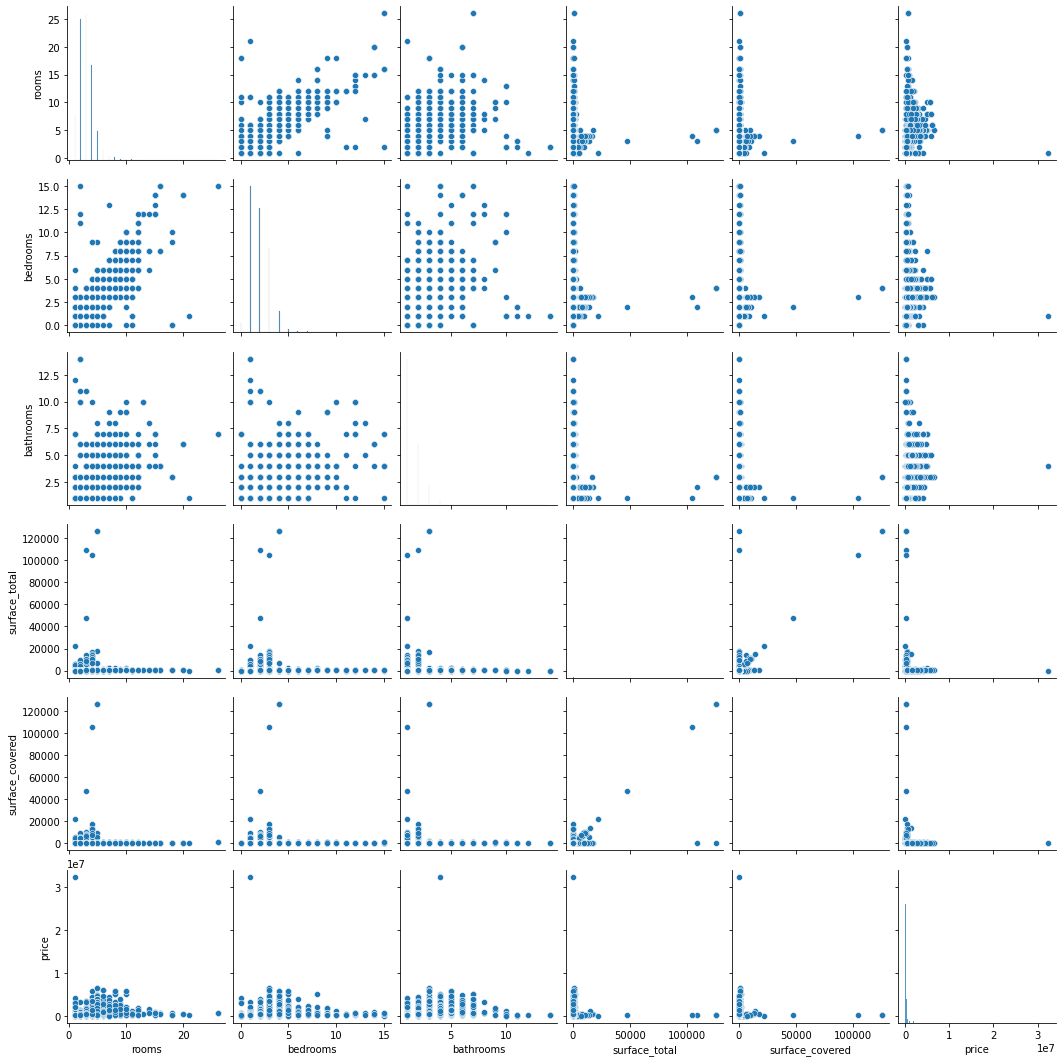

In [16]:
sns.pairplot(properatiEncoded.drop(['propiedad_Casa','propiedad_Departamento','propiedad_PH'],axis=1))

In [13]:
variables = ['bathrooms','bedrooms','rooms','surface_total','surface_covered','price']
properatiSinOutliers = properatiEncoded.copy()

# Acoto los datos a los valores entre +- 3 desviaciones estándar respecto de la media. En caso que la cota mínima sea negativa, la dejo en 0 
for i in variables:
    
#En caso que la cota mínima de la variable sea menor a 0, la trunco a este valor para que no sea negativa
    if properatiEncoded[i].mean() - 3*properatiEncoded[i].std() <0:
        minimo = 0
        maximo = properatiEncoded[i].mean() + 3*properatiEncoded[i].std()
        properatiSinOutliers = properatiSinOutliers[(properatiSinOutliers[i]>minimo)&(properatiSinOutliers[i]<maximo)|(properatiSinOutliers[i]==np.NaN)]

#En caso que la cota mínima de la variable sea mayor a 0, se calcula de la misma forma que la cota máxima
    else:
        minimo = properatiEncoded[i].mean() - 3*properatiEncoded[i].std()
        maximo = properatiEncoded[i].mean() + 3*properatiEncoded[i].std()
        properatiSinOutliers = properatiSinOutliers[(properatiSinOutliers[i]>minimo)&(properatiSinOutliers[i]<maximo)|(properatiSinOutliers[i]==np.NaN)]
    print("Variable",str(i),": valor medio: "+str(properatiEncoded[i].mean()),"STD: ",properatiEncoded[i].std(),"; valor mínimo:",str(minimo),";valor máximo: ",str(maximo))

Variable bathrooms : valor medio: 1.5514893151882823 STD:  0.8540381716808164 ; valor mínimo: 0 ;valor máximo:  4.113603830230732
Variable bedrooms : valor medio: 1.960277641143357 STD:  1.0729463462653566 ; valor mínimo: 0 ;valor máximo:  5.179116679939426
Variable rooms : valor medio: 2.9642782969885775 STD:  1.3147042162707696 ; valor mínimo: 0 ;valor máximo:  6.908390945800886
Variable surface_total : valor medio: 107.99392250095644 STD:  931.8860341323679 ; valor mínimo: 0 ;valor máximo:  2903.65202489806
Variable surface_covered : valor medio: 91.97364595288845 STD:  738.3426802259812 ; valor mínimo: 0 ;valor máximo:  2307.0016866308324
Variable price : valor medio: 259500.25823905558 STD:  322265.44079864415 ; valor mínimo: 0 ;valor máximo:  1226296.580634988


Se puede observar el efecto de la máscara aplicada en la modificación del pairplot respecto al graficado anteriormente

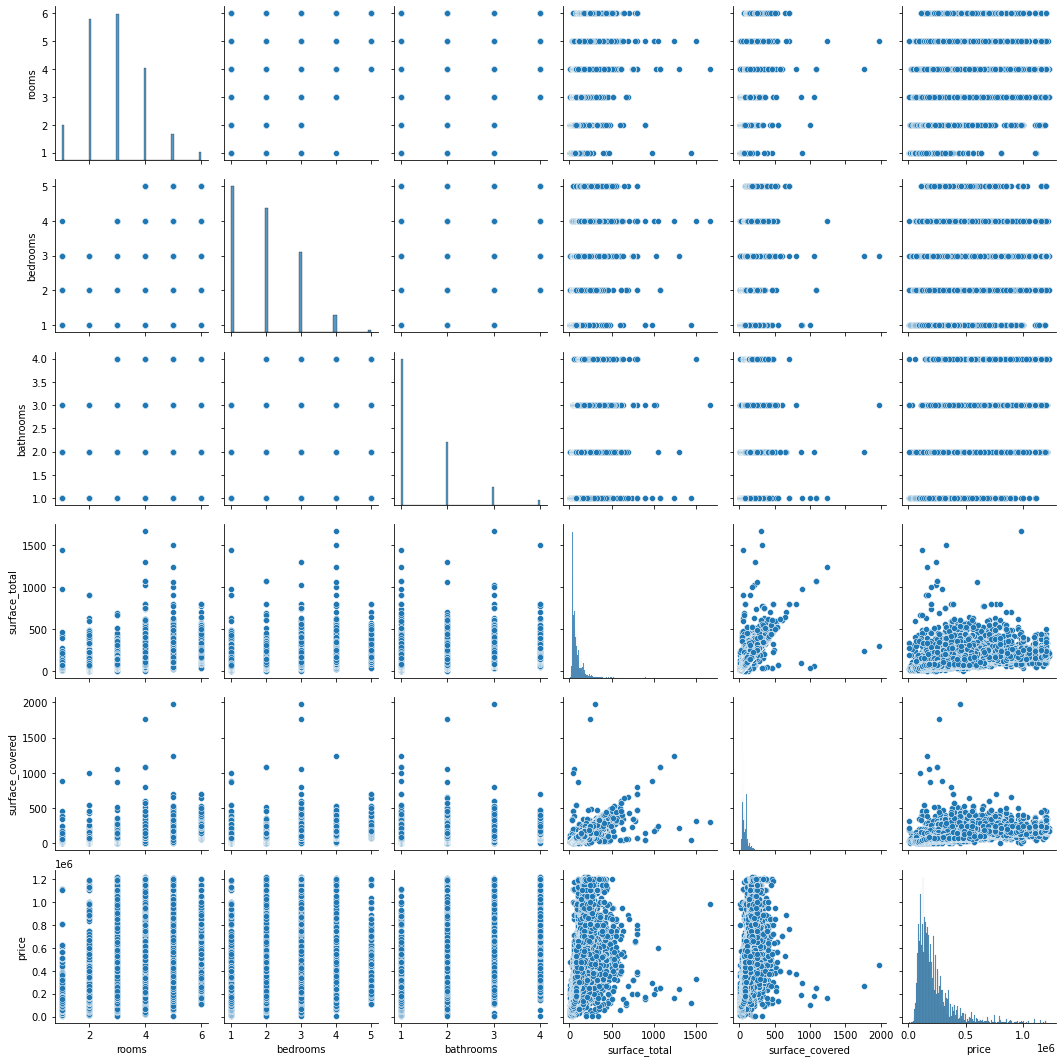

In [14]:
sns.pairplot(properatiSinOutliers.drop(['propiedad_Casa','propiedad_Departamento','propiedad_PH'],axis=1))

## Escalado de datos

Para seleccionar el método de escalado se graficarán en primer lugar las distribuciones de las 6 variables:

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


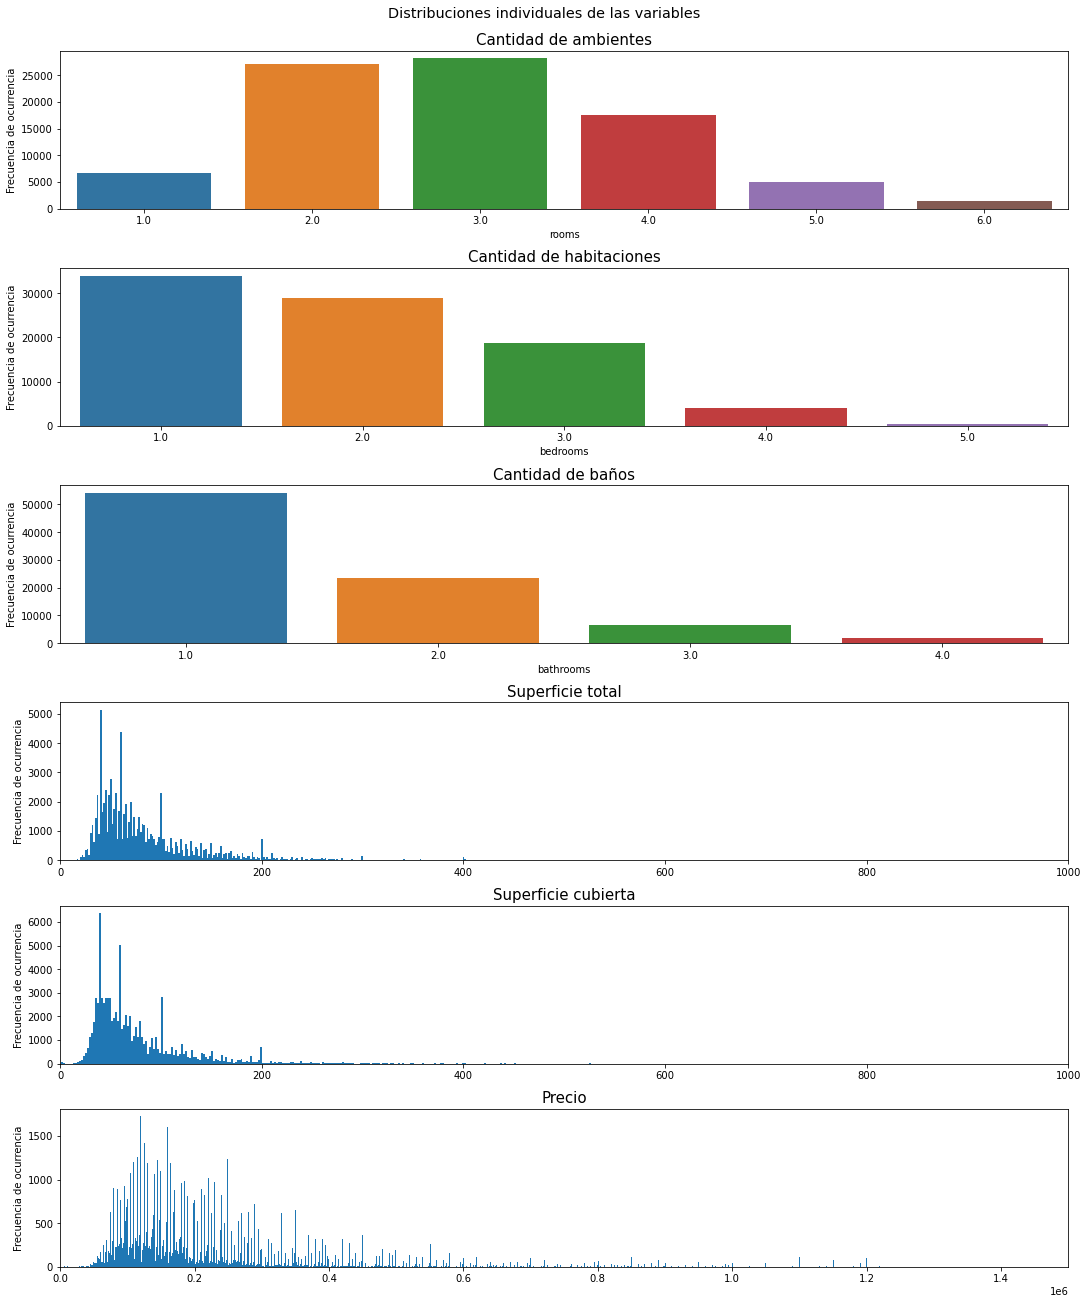

In [15]:
fig, axes = plt.subplots(6, 1, figsize=(15,18), constrained_layout=True)
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

sns.countplot(properatiSinOutliers["rooms"],
              ax=ax1)
ax1.set_ylabel('Frecuencia de ocurrencia')
ax1.set_title("Cantidad de ambientes", fontdict={"fontsize":15})

sns.countplot(properatiSinOutliers["bedrooms"],
              ax=ax2)
ax2.set_ylabel('Frecuencia de ocurrencia')
ax2.set_title("Cantidad de habitaciones", fontdict={"fontsize":15})


sns.countplot(properatiSinOutliers["bathrooms"],
              ax=ax3)
ax3.set_ylabel('Frecuencia de ocurrencia')
ax3.set_title("Cantidad de baños", fontdict={"fontsize":15})

ax4.hist(properatiSinOutliers["surface_total"],
              bins=1000)
ax4.set_xlim(0,1000)
ax4.set_ylabel('Frecuencia de ocurrencia')
ax4.set_title("Superficie total", fontdict={"fontsize":15})

ax5.hist(properatiSinOutliers["surface_covered"],
              bins=1000)
ax5.set_xlim(0,1000)
ax5.set_ylabel('Frecuencia de ocurrencia')
ax5.set_title("Superficie cubierta", fontdict={"fontsize":15})

ax6.hist(properatiSinOutliers["price"],
              bins=1000)
ax6.set_xlim(0,1500000)
ax6.set_ylabel('Frecuencia de ocurrencia')
ax6.set_title("Precio", fontdict={"fontsize":15})


fig.suptitle("Distribuciones individuales de las variables", size= "x-large")
plt.show()

Teniendo en cuenta las formas de las distribuciones del dataset anterior, podemos observar:
- El atributo 'rooms' **(cantidad de ambientes)** posee una distribución normal
- El atributo 'surface_total' **(superficie total)** posee una distribución logarítmica
- El atributo 'surface_covered' **(superficie cubierta)** posee una distribución logarítmica
- El atributo 'price' **(precio)** posee una distribución logarítmica

Para los atributos con distribución normal, aplicaremos una transformación Z-score, mientras que para los de distribución logarítmica aplicaremos transformación logarítmica

Se puede observar en los gráficos de superficie que, debido a la imputación aplicada previamente, hay valores que resultan atípicamente más frecuentes que el resto.

In [ ]:
from sklearn.preprocessing import scale
dataset_transformado = properati_encoded_imputado.copy()

# Transformación Z-Score

atributos = ['rooms', 'bathrooms','bedrooms']
print('Transformación: Z-score')

for i,columna in enumerate(atributos):
    atributo = atributos[i]
    print(f'Columna: {atributo}')
    
    valor_medio = dataset_transformado[atributo].mean()
    std = dataset_transformado[atributo].std()
    dataset_transformado[atributo] = (dataset_transformado[atributo] - valor_medio)/std
    fig, [ax, ax1] = plt.subplots(nrows = 1,ncols = 2,figsize=(20,3)) 
    ax.hist(properatiSinOutliers[atributo],label = 'Dataset reescalado',bins=40)
    ax1.hist(dataset_transformado[atributo],label = 'Dataset sin transformar',bins=40)
    plt.legend()
    plt.show()


# Transformación logarítmica

atributos = ['surface_total', 'surface_covered','price']
print('Transformación: logarítmica')
for i,columna in enumerate(atributos):
    atributo = atributos[i]
    print(f'Columna: {atributo}')
    
    # Aplico transformación logarítmica
    dataset_transformado[atributo] = np.log(dataset_transformado[atributo])
    
    # Normalizo los datos reescalados
    #dataset_transformado[atributo] = (dataset_transformado[atributo]-dataset_transformado[atributo].mean())/dataset_transformado[atributo].std()    
    
    
    fig, [ax, ax1] = plt.subplots(nrows = 1,ncols = 2,figsize=(20,3)) 
    
    ax.hist(properatiSinOutliers[atributo],label = 'Dataset reescalado',bins=100)
    ax1.hist(dataset_transformado[atributo],label = 'Dataset transformado',bins=100)
    
    plt.legend()
    plt.show()

Se puede observar que las variables normalizadas poseen distribuciones similares, permitiendo compararlas posteriormente en un modelo de Machine Learning

In [ ]:
sns.pairplot(dataset_transformado.drop(['propiedad_Casa','propiedad_Departamento','propiedad_PH'],axis=1))

## Modelo proyecto 1

A continuación, reentrenaré el modelo del proyecto 1 para comparar su desempeño con el modelo obtenido luego del preprocesamiento propuesto en el presente informe

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Cargo el dataset
properati = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')

# Filtro propiedades de tipo PH, departamento o casa ubicadas en Capital Federal 
filtrado = properati[properati.property_type.isin(['PH','Departamento','Casa'])& properati.l2.isin(['Capital Federal'])]

# Filtro propiedades de superficie total superior a 15 e inferior a 1000
filtrado = filtrado[(filtrado['surface_total'] >= 15) & (filtrado['surface_total'] <= 1000)]

# Filtro propiedades de precio inferior a $4.000.000
filtrado = filtrado[(filtrado['price'] <= 4000000)]

# Separo los atributos que no sean cantidad de ambientes, habitaciones, baños, superficie total, superficie cubierta y precio
filtrado = filtrado.drop(columns=['lat','lon','start_date','end_date','created_on','l1','l2','l3','currency','title','description','operation_type','property_type'])

# Descarto las instancias con valores faltantes
filtrado = filtrado.dropna(axis=0)

# Selecciono las variables predictoras y la variable a predecir
X = filtrado.drop(columns= ['price'])
y = filtrado['price']

# Realizo un train/test/split 70-30%
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state = 5)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Selecciono el mejor modelo de regresión (árbol de decision) y el hiperparámetro optimo (k=22)
tree_regressor = DecisionTreeRegressor(max_depth=22,random_state=42)

# Entreno el modelo
tree_regressor.fit(X_train, y_train)

# Realizo predicciones para el set de entrenamiento y evaluación
y_train_pred = tree_regressor.predict(X_train)
y_test_pred = tree_regressor.predict(X_test)

# Calculo el RMSE para ambos sets
rmse_accTrain = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_accTest = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Imprimo el resultado
print("El RMSE del modelo de árbol de decisión en train es:",rmse_accTrain)
print("El RMSE del modelo de árbol de decisión en test es:",rmse_accTest)

Vuelvo a calcular el k para el dataset con el preprocesamiento propuesto

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Cargo el dataset
filtrado = dataset_transformado.copy()

# Selecciono las variables predictoras y la variable a predecir
X = filtrado.drop(columns= ['price'])
y = filtrado['price']

# Realizo un train/test/split 70-30%
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state = 5)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


# Defino las listas vacías para los valores de accuracy deseados
rmse_accuracy_train = []
rmse_accuracy_test = []

# Defino la lista de valores de profundidad del árbol
max_depths = np.arange(1,35)

# Genero un loop sobre los distintos valores de profundidad 
for max_depth in max_depths:
    
    # Defino el modelo con el valor de profundidad
    rgrT = DecisionTreeRegressor(max_depth = max_depth, random_state=42)
    
    # Entreno el modelo
    rgrT.fit(X_train,y_train)
    
    # Evalúo sobre el set de entrenamiento
    y_train_pred = rgrT.predict(X_train)
    rmse_accTrain = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(y_train_pred)))
    
    # Evalúo sobre el set de evaluación
    y_test_pred = rgrT.predict(X_test)
    rmse_accTest = np.sqrt(mean_squared_error(np.exp(y_test),np.exp(y_test_pred)))
    
    # Agrego la información a las listas
    rmse_accuracy_train.append(rmse_accTrain)
    rmse_accuracy_test.append(rmse_accTest)
    
    rmse_dt_min = min(rmse_accuracy_test)
    dt_min = rmse_accuracy_test.index(min(rmse_accuracy_test))+1

    
    
print('RMSE mínimo en test de '+"${:,.2f}". format(rmse_accTest.min()),
      ', correspondiente a la profundidad k = ',
     f"{rmse_accuracy_test.index(min(rmse_accuracy_test))+1}")

# Conclusión

Podemos observar, a partir de los resultados expuestos más arriba, que el preprocesamiento propuesto del dataset reduce solamente en un **2.4%** el RMSE, cantidad que resulta escasa teniendo en cuenta que el error en sí sigue resultando significativo para el problema que intenta solucionar

# Parte B - Modelos avanzados

Elige dos de los modelos avanzados vistos (en el caso de regresión, considera una regresión lineal con atributos polinómicos y regularización). Entrénalos y evalúalos con sus argumentos por defecto. No te olvides de hacer un train/test split y usar Validación Cruzada.

Optimiza sus hiperparámetros mediante Validación Cruzada y Grid Search o Random Search.

Compara el desempeño de los nuevos modelos entre sí y con el modelo de la Parte A. ¿Cuál elegirías? Justifica.

## al menos un modelo debe ser optimizado por Grid Search o Random Search; el otro puede ser optimizado por búsqueda manual (es decir, puedes dejar los mejores parámetros que encontraste probando )

### En la optimización de hiperparámetros, debes justificar los parámetros que elegiste para optimizar y el rango de cada uno.

# Parte C - Interpretación de datos

De acuerdo a lo que el modelo permite, responde algunas o todas las siguientes preguntas:

¿Qué variables fueron relevantes para el modelo para hacer una predicción? ¿Cuáles no? Si usaste una regresión lineal con regularización, presta atención a los parámetros (pendientes) obtenidas. Si usaste un modelo de ensamble en árboles, además de ver la importancia de cada atributo, también elige algunos árboles al azar y observa qué atributos considera importantes. ¿En qué se diferencian esos árboles? ¿Por qué? Finalmente, responde, ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?

¿Cómo es la distribución de errores (regresión) o qué clases se confunden entre sí (clasificación)? ¿Dónde falla? ¿A qué se debe?

## responder al menos una pregunta. Obviamente, ¡cuanto más hagas, más aprenderás y mejor será tu proyecto!

#### Debes estudiar qué variables utiliza el modelo para predecir y responder la pregunta: ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?

#### Es muy importante que analices los errores del modelo. ¿Dónde es mayor el error? ¿dónde acierta?

#### Debes ser crítico/a con la metodología utilizada. ¿Qué mejorarías?

# Desafío opcional

Aplica una técnica de Clustering sobre el dataset. Puedes combinar con técnicas de reducción de dimensionalidad para facilitar la visualización. ¿Qué clusters encuentras? ¿A qué pueden corresponder? Te dejamos preguntas que pueden servir como disparadoras: ¿qué barrios se parecen más entre sí?¿qué tipos de propiedades se parecen más entre sí?